In [21]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter, offset_image
from src.analysis.embedded import calculate_vocabulary_variation, embedded_CIs, read_embeddings
from settings import AMBIGUITY_PATH, AMBIGUITY_VARIATION, EMBEDDINGS_PATH

pd.set_option('mode.chained_assignment', None)

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)

In [3]:
variations.head()

,emoji,vocabulary,variation,mode_embedding,CIs
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,[-9.0013e-01 -4.3639e-03 4.7695e-01 1.4165e-...,"[0.35837585716197884, 0.6267261994754275]"
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,[ 4.6689e-02 -2.3131e-01 6.4926e-01 -2.9223e-...,"[0.41200086324362406, 0.7542600946038873]"
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,[-0.10602 -0.010289 -0.25982 0.52433 ...,"[0.1401009645106064, 0.4201737316739228]"
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,[ 3.6664e-01 -4.0631e-01 2.3680e-01 2.9964e-...,"[0.4139707032711831, 0.7217792813700658]"
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,[ 0.80197 -1.3284 0.83488 -0.13458 ...,"[0.3517648566963858, 0.6258342967978838]"


In [7]:
pd.set_option('display.max_colwidth', None)
df = variations[variations.emoji.isin(['🛃', '❤️', '😂', '➿', '🈺', '👩‍👩‍👦', '👷', '💯', '😻'])][["emoji", "vocabulary"]]
df

,emoji,vocabulary
149,❤️,"Counter({'love': 16, 'heart': 10})"
155,➿,"Counter({'loops': 4, 'sign': 3, 'glasses': 2, 'astrology': 2, 'symbol': 1, 'libra': 1, 'wire': 1, 'curl': 1, 'curlicue': 1, 'coils': 1, 'loopy': 1, 'pig nose': 1, 'swirl': 1, 'forever': 1, 'curls': 1, 'zodiac': 1, 'wave': 1, 'cord': 1, 'spiral': 1, 'swirly': 1, 'loop': 1, 'twirling': 1, 'repeat': 1})"
198,🈺,"Counter({'symbol': 7, 'robot': 4, 'chinese': 4, 'connection': 1, 'logo': 1, 'google voice': 1, 'phone': 1, 'character': 1, 'computer': 1, 'television': 1, 'g': 1, 'korea': 1, 'unknown': 1, 'japanese': 1, 'dunno': 1, 'mahjong': 1, 'not sure': 1, 'to': 1})"
611,👩‍👩‍👦,"Counter({'family': 28, 'people': 1, 'adoption': 1})"
642,👷,"Counter({'construction': 11, 'worker': 11, 'plumber': 1, 'engineer': 1, 'man': 1, 'fire service': 1, 'work': 1})"
698,💯,"Counter({'hundred': 12, 'perfect': 4, 'agreed': 1, 'winner': 1, 'approval': 1, 'anniversary': 1, 'complete': 1, 'great': 1, 'percent': 1, 'agree': 1, 'hundred pere cent': 1, 'a': 1, 'great job': 1, 'one hundred': 1, 'sure': 1, 'numbers': 1})"
892,😂,"Counter({'laughing': 6, 'laugh': 5, 'crying': 5, 'funny': 3, 'lol': 2, 'cry': 2, 'laugher': 1, 'laughingsohardimcrying': 1, 'joy': 1, 'happy sad': 1, 'liao': 1})"
949,😻,"Counter({'love': 25, 'inlove': 2, 'happy': 1, 'attraction': 1, 'cat': 1})"
1036,🛃,"Counter({'mailman': 3, 'police': 3, 'conductor': 2, 'cop': 2, 'bus': 2, 'man': 1, 'signal': 1, 'trash man': 1, 'computer': 1, 'inspection': 1, 'police sign': 1, 'worker': 1, 'postal': 1, 'guard': 1, 'monitor': 1, 'symbol': 1, 'officer': 1, 'postman': 1, 'fare': 1, 'driver': 1, 'recycle': 1})"


In [9]:
variations = variations.set_index("emoji")

### Create randomized baseline

In [23]:
ambiguity = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')
word_embeddings = read_embeddings(EMBEDDINGS_PATH)
words = ambiguity.word

In [24]:
baselines = []
for i in tqdm(range(1000)):
    random_words = words.sample(n=30, random_state=42+i).tolist()
    random_voc = Counter(random_words)
    baselines.append(calculate_vocabulary_variation(random_voc, word_embeddings)[0])

In [25]:
alpha = 5
baseline = np.nanmedian(np.array(baselines))
baselines_CIs = [np.nanpercentile(baselines, alpha / 2),\
                         np.nanpercentile(baselines, 100 - (alpha / 2))] 

In [26]:
baseline

0.6860900973280272

In [27]:
baselines_CIs

[0.5707602351453775, 0.8834659105717826]

#### Which emojis are only a bit more ambiguous than baseline?

In [13]:
variations[variations.variation.sub(baseline).gt(0.01)]["variation"]

emoji
💁    0.713159
💌    0.700732
📵    0.702734
🛂    0.716157
🛃    0.745275
🧻    0.698550
Name: variation, dtype: float64

#### Which emojis are very close to baseline? Both sides, a bit lower than baseline, a bit higher than baseline

In [14]:
variations[variations.variation.sub(baseline).abs().lt(0.01)]["variation"]

emoji
⛎      0.692086
➿      0.692479
👩‍💼    0.689072
🧐      0.694345
Name: variation, dtype: float64

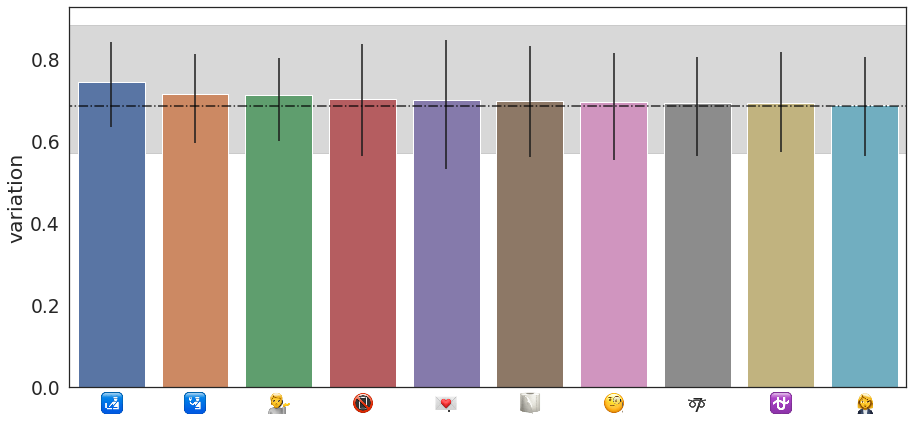

In [15]:
top_ten = variations.nlargest(10, columns='variation').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(top_ten, ax, col='variation')

In [16]:
ax.get_xlim()

(-0.5, 9.5)

In [17]:
ax.get_ylim()

(0.0, 0.9276392061003718)

Text(0, 0.5, 'variation')

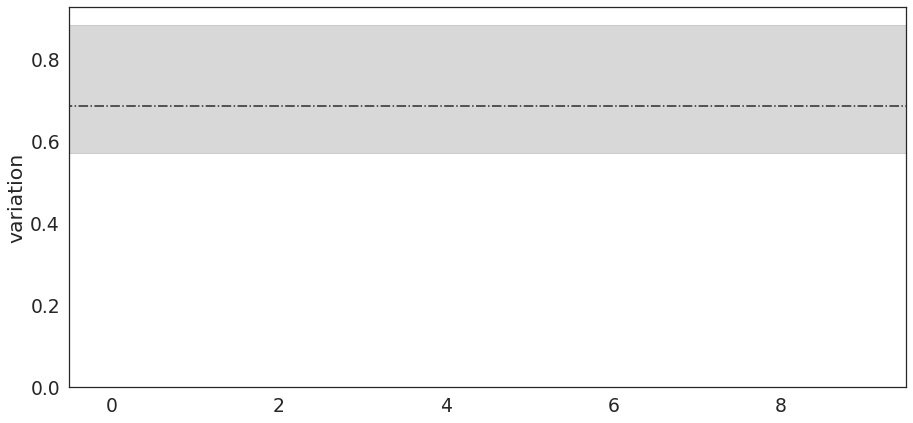

In [18]:
fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
ax.set_ylim(0.0, 0.9276392061003718)
ax.set_xlim(-0.5, 9.5)
ax.set_ylabel("variation")
# plot_emoji_barplot(top_ten, ax, col='variation')

In [19]:
top_ten[['emoji', 'vocabulary']].iloc[5].vocabulary

"Counter({'toiletpaper': 7, 'paper': 7, 'bathroom': 3, 'tissue': 3, 'tp': 2, 'roll': 2, 'toilet paper': 1, 'toilet': 1, 'pipe': 1, 'bandage': 1, 'whip e': 1})"

In [20]:
top_ten[['emoji', 'vocabulary']].iloc[9].vocabulary

"Counter({'businesswoman': 6, 'teacher': 2, 'presentation': 2, 'work': 1, 'co': 1, 'statistics': 1, 'women': 1, 'scientist': 1, 'executive': 1, 'profession': 1, 'graph': 1, 'present or': 1, 'analyst': 1, 'reporter': 1, 'chart': 1, 'accountant': 1, 'worker': 1, 'meeting': 1, 'corporate': 1, 'stocks': 1, 'leader': 1, 'business': 1, 'woman': 1})"

In [21]:
top_ten[['emoji', 'vocabulary']].iloc[2].vocabulary

"Counter({'server': 4, 'boy': 3, 'fancy': 2, 'sassy': 2, 'bye': 1, 'confused': 1, 'hi': 1, 'obvious': 1, 'sarcastic': 1, 'presenting': 1, 'maybe': 1, 'person': 1, 'give': 1, 'hello': 1, 'flex': 1, 'whatever': 1, 'wave': 1, 'action': 1, 'me please': 1, 'showoff': 1, 'cute': 1, 'lift up': 1, 'surprise': 1, 'not concern': 1, 'raise': 1, 'serve': 1})"

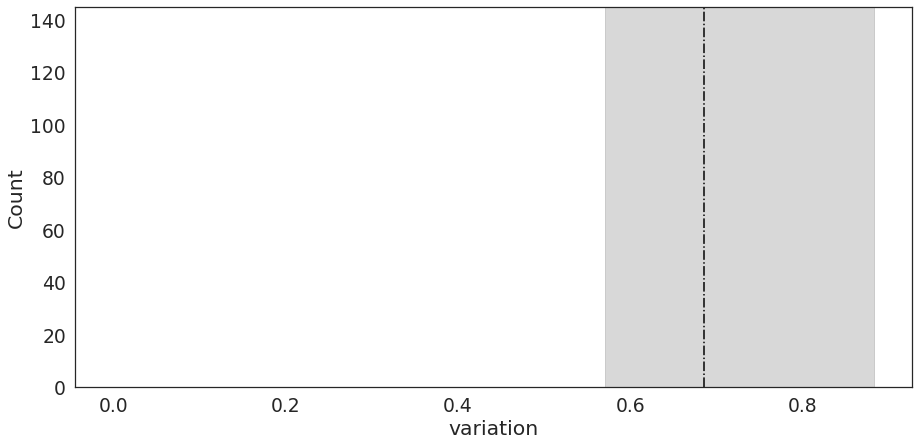

In [32]:
fig, ax = plt.subplots()
ax.axvline(baseline, linestyle="-.", color='black')
ax.axvspan(baselines_CIs[0], baselines_CIs[1], alpha=0.3, color='gray')
ax.set_ylim(0.0, 144.9)
ax.set_xlim(-0.04417329552858913, 0.9276392061003718)
ax.set_ylabel("Count")
ax.set_xlabel("variation");

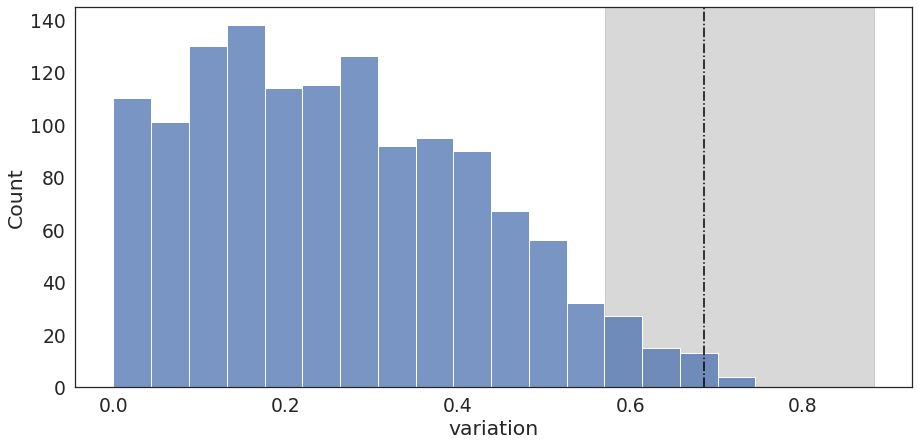

In [28]:
fig, ax = plt.subplots()
ax.axvline(baseline, linestyle="-.", color='black')
ax.axvspan(baselines_CIs[0], baselines_CIs[1], alpha=0.3, color='gray')
sns.histplot(variations.variation, ax=ax);

In [30]:
ax.get_xlim()
ax.get_ylim()

(0.0, 144.9)

In [23]:
variations.describe()

,variation
count,1325.000000
mean,0.262528
std,0.164641
min,0.000000
25%,0.128927
50%,0.247732
75%,0.383371
max,0.745275
